## Load Cleaned Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import Image

test = pd.read_csv("../data/cleaned/test.csv")
control = pd.read_csv("../data/cleaned/control.csv")
demo = pd.read_csv("../data/cleaned/demo.csv")
exp = pd.read_csv("../data/cleaned/exp.csv")

## Client Profile
1. Who are the primary clients using this online process?
2. Are the primary clients younger or older, new or long-standing?
3. Next, carry out a client behaviour analysis to answer any additional relevant questions you think are important.


In [ ]:
demo_exp = pd.merge(demo, exp, on="client_id")

In [ ]:
demo_exp.client_id.nunique()

In [ ]:
sns.histplot(demo['clnt_age'], kde=True, bins=30, color='red').set_title("Client's Age Distribution")

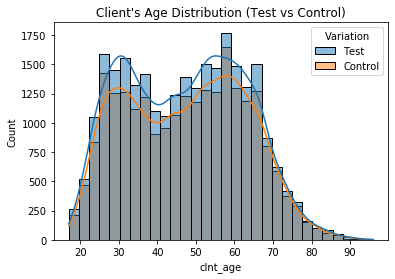

In [486]:
sns.histplot(data=demo_exp, x="clnt_age", hue="Variation", kde=True, bins=30, color='red').set_title("Client's Age Distribution (Test vs Control)");

Text(0.5, 1.0, "Client's Age Distribution (Control Group)")

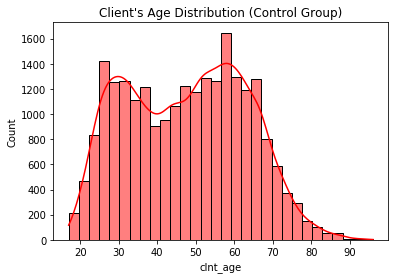

In [485]:
sns.histplot(demo_exp['clnt_age'][demo_exp["Variation"]=="Control"], kde=True, bins=30, color='red').set_title("Client's Age Distribution (Control Group)")

Text(0.5, 1.0, "Client's Age Distribution (Test Group)")

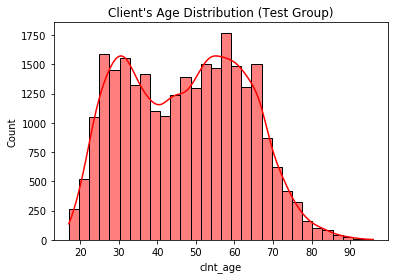

In [484]:
sns.histplot(demo_exp['clnt_age'][demo_exp["Variation"]=="Test"], kde=True, bins=30, color='red').set_title("Client's Age Distribution (Test Group)")

Age distribution between Control & Test Group are relatively the same with the whole clients data in demo.

In [ ]:
demo_exp.describe().round()

In [ ]:
sns.histplot(demo['clnt_tenure_yr'], kde=True, bins=30, color='red')

In [ ]:
sns.scatterplot(demo, x='clnt_age', y='clnt_tenure_yr')

In [ ]:
pd.crosstab(demo["calls_6_mnth"], demo["logons_6_mnth"])

In [481]:
demo['log_bal'] = np.log1p(demo['bal'])

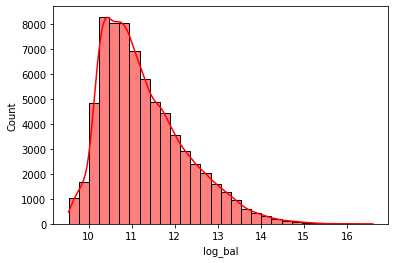

In [482]:
sns.histplot(demo['log_bal'], kde=True, bins=30, color='red')

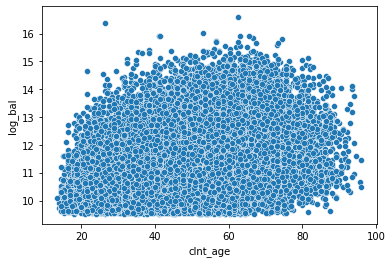

In [483]:
sns.scatterplot(demo, x='clnt_age', y='log_bal')

In [ ]:
sns.scatterplot(demo[demo["bal"]<2000000], x='clnt_age', y='bal')

## Performance Metrics

1. Completion Rate: The proportion of users who reach the final ‘confirm’ step.
2. Time Spent on Each Step: The average duration users spend on each step.
3. Error Rates: If there’s a step where users go back to a previous step, it may indicate confusion or an error. You should consider moving from a later step to an earlier one as an error.
4. Other metrics

### 1. Completion Rate: The proportion of users who reach the final ‘confirm’ step.

Assumption:
- No matter from which visitor_id or visit_id, as long as the client_id follow the process_step sequentially (start > step 1 > step 2 > step 3 > confirm), the process is considered complete.

#### Completion Rate (Test Group)

In [3]:
# Create pivot dataframe (if the client_id has duplicate in 'visit_id' and 'process_step' -> keep the last)
test_pivot = test.drop_duplicates(subset=['client_id', 'visitor_id', 'visit_id','process_step'], keep='last')
test_pivot = test_pivot.pivot(index=['client_id', 'visitor_id', 'visit_id'], columns='process_step', values='date_time')
test_pivot = test_pivot.reset_index()
test_pivot = test_pivot[['client_id','visitor_id','visit_id','start','step_1','step_2','step_3','confirm']]

#Create dummy variable for each step (1=there is timestamp in particular step; 0=otherwise)
test_pivot['start_count'] = test_pivot[['start']].notna().sum(axis=1)
test_pivot['step_1_count'] = test_pivot[['step_1']].notna().sum(axis=1)
test_pivot['step_2_count'] = test_pivot[['step_2']].notna().sum(axis=1)
test_pivot['step_3_count'] = test_pivot[['step_3']].notna().sum(axis=1)
test_pivot['confirm_count'] = test_pivot[['confirm']].notna().sum(axis=1)

# Sum of count of log by each client_id (Note: some client_id may have >1 count in particular step)
test_count_log = test_pivot.groupby('client_id')[['start_count','step_1_count','step_2_count','step_3_count','confirm_count']].sum().reset_index()

# Create dummy variable which identify client_id who reached specific step
CR_test = test_count_log[['client_id', 'start_count', 'step_1_count', 'step_2_count','step_3_count', 'confirm_count']]
CR_test['start'] = CR_test['start_count'].apply(lambda x: 1 if x >= 1 else 0)
CR_test['step_1'] = CR_test['step_1_count'].apply(lambda x: 1 if x >= 1 else 0)
CR_test['step_2'] = CR_test['step_2_count'].apply(lambda x: 1 if x >= 1 else 0)
CR_test['step_3'] = CR_test['step_3_count'].apply(lambda x: 1 if x >= 1 else 0)
CR_test['confirm'] = CR_test['confirm_count'].apply(lambda x: 1 if x >= 1 else 0)

# Not counting client_id who does not have timestamp on the previous step (sequentially)
CR_test.loc[CR_test['step_3'] == 0, 'confirm'] = 0
CR_test.loc[CR_test['step_2'] == 0, 'step_3'] = 0
CR_test.loc[CR_test['step_1'] == 0, 'step_2'] = 0
CR_test.loc[CR_test['start'] == 0, 'step_1'] = 0

# Final Completion Rate
Completion_Rate_test = CR_test[['start','step_1','step_2','step_3','confirm']].sum().reset_index()
Completion_Rate_test.columns = ['process_step', 'num_users']
Completion_Rate_test[["CR_test"]] = round(Completion_Rate_test[["num_users"]] / Completion_Rate_test["num_users"][0] *100,2)

#### Completion Rate (Control Group)

In [4]:
# Create pivot dataframe (if the client_id has duplicate in 'visit_id' and 'process_step' -> keep the last)
control_pivot = control.drop_duplicates(subset=['client_id', 'visitor_id', 'visit_id','process_step'], keep='last')
control_pivot = control_pivot.pivot(index=['client_id', 'visitor_id', 'visit_id'], columns='process_step', values='date_time')
control_pivot = control_pivot.reset_index()
control_pivot = control_pivot[['client_id','visitor_id','visit_id','start','step_1','step_2','step_3','confirm']]

#Create dummy variable for each step (1=there is timestamp in particular step; 0=otherwise)
control_pivot['start_count'] = control_pivot[['start']].notna().sum(axis=1)
control_pivot['step_1_count'] = control_pivot[['step_1']].notna().sum(axis=1)
control_pivot['step_2_count'] = control_pivot[['step_2']].notna().sum(axis=1)
control_pivot['step_3_count'] = control_pivot[['step_3']].notna().sum(axis=1)
control_pivot['confirm_count'] = control_pivot[['confirm']].notna().sum(axis=1)

# Sum of count of log by each client_id (Note: some client_id may have >1 count in particular step)
control_count_log = control_pivot.groupby('client_id')[['start_count','step_1_count','step_2_count','step_3_count','confirm_count']].sum().reset_index()

# Create dummy variable which identify client_id who reached specific step
CR_control = control_count_log[['client_id', 'start_count', 'step_1_count', 'step_2_count','step_3_count', 'confirm_count']]
CR_control['start'] = CR_control['start_count'].apply(lambda x: 1 if x >= 1 else 0)
CR_control['step_1'] = CR_control['step_1_count'].apply(lambda x: 1 if x >= 1 else 0)
CR_control['step_2'] = CR_control['step_2_count'].apply(lambda x: 1 if x >= 1 else 0)
CR_control['step_3'] = CR_control['step_3_count'].apply(lambda x: 1 if x >= 1 else 0)
CR_control['confirm'] = CR_control['confirm_count'].apply(lambda x: 1 if x >= 1 else 0)

# Not counting client_id who does not have timestamp on the previous step (sequentially)
CR_control.loc[CR_control['step_3'] == 0, 'confirm'] = 0
CR_control.loc[CR_control['step_2'] == 0, 'step_3'] = 0
CR_control.loc[CR_control['step_1'] == 0, 'step_2'] = 0
CR_control.loc[CR_control['start'] == 0, 'step_1'] = 0

# Final Completion Rate
Completion_Rate_control = CR_control[['start','step_1','step_2','step_3','confirm']].sum().reset_index()
Completion_Rate_control.columns = ['process_step', 'num_users']
Completion_Rate_control[["CR_control"]] = round(Completion_Rate_control[["num_users"]] / Completion_Rate_control["num_users"][0] *100,2)

In [328]:
Completion_Rate_test

,process_step,num_users,CR_test
0,start,26679,100.00
1,step_1,24201,90.71
2,step_2,22243,83.37
3,step_3,20834,78.09
4,confirm,18445,69.14


In [329]:
Completion_Rate_control

,process_step,num_users,CR_control
0,start,23397,100.00
1,step_1,20082,85.83
2,step_2,18633,79.64
3,step_3,17356,74.18
4,confirm,15329,65.52


### 2. Time Spent on Each Step: The average duration users spend on each step.

Assumption:

#### Completion Duration (Test Group)

In [22]:
# Create pivot dataframe (if the client_id has duplicate in 'visit_id' and 'process_step' -> keep the last)
test_pivot = test.drop_duplicates(subset=['client_id', 'visitor_id', 'visit_id','process_step'], keep='last')
test_pivot = test_pivot.pivot(index=['client_id', 'visitor_id', 'visit_id'], columns='process_step', values='date_time')
test_pivot = test_pivot.reset_index()
test_time = test_pivot[['client_id','visitor_id','visit_id','start','step_1','step_2','step_3','confirm']]

steps = ['start','step_1','step_2','step_3','confirm']
for step in steps:
    test_time[step] = pd.to_datetime(test_time[step])
    
test_time["start_dur"] = test_time["step_1"] - test_time["start"]
test_time["step_1_dur"] = test_time["step_2"] - test_time["step_1"] 
test_time["step_2_dur"] = test_time["step_3"] - test_time["step_2"] 
test_time["step_3_dur"] = test_time["confirm"] - test_time["step_3"] 

durs = ['start_dur','step_1_dur','step_2_dur','step_3_dur']
for dur in durs:
    test_time[dur] = test_time[dur].apply(lambda x: x if x >= pd.Timedelta(0) else pd.NaT)
    #test_time[dur] = test_time[dur].apply(lambda x: f"{int(x.total_seconds() // 60):02}:{int(x.total_seconds() % 60):02}" if pd.notnull(x) else np.nan)
    
time_test = test_time[['start_dur','step_1_dur','step_2_dur','step_3_dur']].mean().reset_index()
time_test.columns = ['process_step', 'duration']

#### Completion Duration (Control Group)

In [6]:
# Create pivot dataframe (if the client_id has duplicate in 'visit_id' and 'process_step' -> keep the last)
control_pivot = control.drop_duplicates(subset=['client_id', 'visitor_id', 'visit_id','process_step'], keep='last')
control_pivot = control_pivot.pivot(index=['client_id', 'visitor_id', 'visit_id'], columns='process_step', values='date_time')
control_pivot = control_pivot.reset_index()
control_time = control_pivot[['client_id','visitor_id','visit_id','start','step_1','step_2','step_3','confirm']]

steps = ['start','step_1','step_2','step_3','confirm']
for step in steps:
    control_time[step] = pd.to_datetime(control_time[step])
    
control_time["start_dur"] = control_time["step_1"] - control_time["start"]
control_time["step_1_dur"] = control_time["step_2"] - control_time["step_1"] 
control_time["step_2_dur"] = control_time["step_3"] - control_time["step_2"] 
control_time["step_3_dur"] = control_time["confirm"] - control_time["step_3"] 

durs = ['start_dur','step_1_dur','step_2_dur','step_3_dur']
for dur in durs:
    control_time[dur] = control_time[dur].apply(lambda x: x if x >= pd.Timedelta(0) else pd.NaT)
    #control_time[dur] = control_time[dur].apply(lambda x: f"{int(x.total_seconds() // 60):02}:{int(x.total_seconds() % 60):02}" if pd.notnull(x) else np.nan)
    
time_control = control_time[['start_dur','step_1_dur','step_2_dur','step_3_dur']].mean().reset_index()
time_control.columns = ['process_step', 'duration']

In [348]:
time_test

,process_step,duration
0,start_dur,0 days 00:00:49.330020809
1,step_1_dur,0 days 00:00:50.851985402
2,step_2_dur,0 days 00:01:42.118102065
3,step_3_dur,0 days 00:02:23.443006308


In [351]:
time_control

,process_step,duration
0,start_dur,0 days 00:00:54.578368944
1,step_1_dur,0 days 00:00:51.818625393
2,step_2_dur,0 days 00:01:39.330432829
3,step_3_dur,0 days 00:02:15.819548872


In [21]:
control

,client_id,visitor_id,visit_id,process_step,date_time,Variation,step_number
0,1028,42237450_62128060588,557292053_87239438319_391157,start,2017-04-08 18:51:28,Control,1
1,1028,42237450_62128060588,557292053_87239438319_391157,step_1,2017-04-08 18:52:17,Control,2
2,1028,42237450_62128060588,557292053_87239438319_391157,step_1,2017-04-08 18:53:20,Control,2
3,1028,42237450_62128060588,557292053_87239438319_391157,step_2,2017-04-08 18:53:29,Control,3
4,1028,42237450_62128060588,557292053_87239438319_391157,step_3,2017-04-08 18:58:04,Control,4
...,...,...,...,...,...,...,...
140531,9998346,292425655_16607136645,189177304_69869411700_783154,step_2,2017-03-29 15:30:11,Control,3
140532,9998346,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:30:25,Control,4
140533,9998346,292425655_16607136645,189177304_69869411700_783154,confirm,2017-03-29 15:37:28,Control,5
140534,9998346,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:37:28,Control,4


In [480]:
control_time.describe()

process_step,client_id,start_dur,step_1_dur,step_2_dur,step_3_dur
count,3.224300e+04,21201,19060,17813,15295
mean,5.020892e+06,0 days 00:00:54.578368944,0 days 00:00:51.818625393,0 days 00:01:39.330432829,0 days 00:02:15.819548872
std,2.870857e+06,0 days 00:02:20.721556333,0 days 00:01:37.212302749,0 days 00:02:18.046096432,0 days 00:03:41.644279729
min,1.028000e+03,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
25%,2.532470e+06,0 days 00:00:09,0 days 00:00:10,0 days 00:00:38,0 days 00:00:44
50%,5.034090e+06,0 days 00:00:19,0 days 00:00:22,0 days 00:01:08,0 days 00:01:17
75%,7.479669e+06,0 days 00:00:45,0 days 00:00:54,0 days 00:01:55,0 days 00:02:28
max,9.998921e+06,0 days 01:53:42,0 days 00:49:18,0 days 01:20:15,0 days 02:37:41


### 3. Error Rate

If there’s a step where users go back to a previous step, it may indicate confusion or an error. You should consider moving from a later step to an earlier one as an error.

Assumption:
- Confirm > Start (We don't consider it as an error, because we consider it as the session ended correctly and user starts a new session)

Errors are in <b>red cirlces</b>

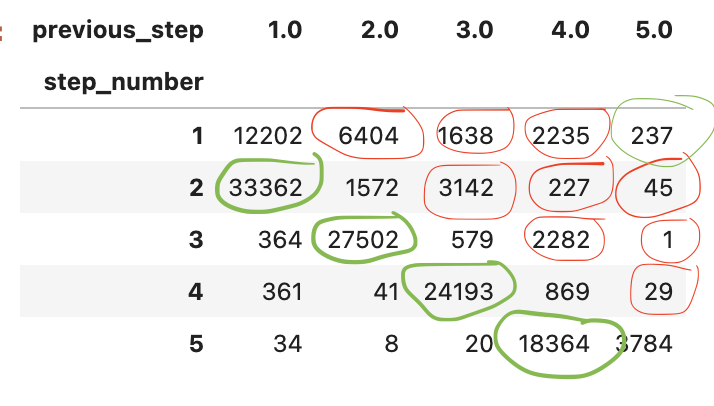

In [471]:
Image("../figures/error_current_previous.png")

#### Error Rate (Test Group)

In [7]:
step_mapping = {'start': 1, 'step_1': 2, 'step_2': 3, 'step_3': 4, 'confirm': 5}

error_test = test
error_test['step_number'] = error_test['process_step'].map(step_mapping)
error_test = error_test.sort_values(by=['client_id', 'visitor_id', 'visit_id', 'date_time'])

# Shift the step_number to compare with the previous step for the same user
error_test['previous_step'] = error_test.groupby(['client_id', 'visitor_id','visit_id'])['step_number'].shift(1)

# Create the error column: 1 if moving to an earlier step, 0 otherwise
error_test['error'] = (error_test['step_number'] < error_test['previous_step']).astype(int)

# Replacing error = 0 for confirm > start
error_test['error'] = np.where((error_test["step_number"]==1) & (error_test["previous_step"]==5), 0, error_test['error'])

# Total Number of Errors by Process Step
error_test_bystep = error_test.groupby('previous_step')[['error']].sum().reset_index()

error_test = error_test.groupby('client_id')[['error']].sum().reset_index()
error_test["error"] = error_test['error'].apply(lambda x: 1 if x >= 1 else 0)
error_test[["total_client"]] = 1
error_test = error_test[['error','total_client']].sum()
error_rate_test = round(error_test["error"]/error_test["total_client"]*100,2)

#### Error Rate (Control Group)

In [8]:
step_mapping = {'start': 1, 'step_1': 2, 'step_2': 3, 'step_3': 4, 'confirm': 5}

error_control = control
error_control['step_number'] = error_control['process_step'].map(step_mapping)
error_control = error_control.sort_values(by=['client_id', 'visitor_id', 'visit_id', 'date_time'])

# Shift the step_number to compare with the previous step for the same user
error_control['previous_step'] = error_control.groupby(['client_id', 'visitor_id','visit_id'])['step_number'].shift(1)

# Create the error column: 1 if moving to an earlier step, 0 otherwise
error_control['error'] = (error_control['step_number'] < error_control['previous_step']).astype(int)

# Replacing error = 0 for confirm > start
error_control['error'] = np.where((error_control["step_number"]==1) & (error_control["previous_step"]==5), 0, error_control['error'])

# Total Number of Errors by Process Step
error_control_bystep = error_control.groupby('previous_step')[['error']].sum().reset_index()

error_control = error_control.groupby('client_id')[['error']].sum().reset_index()
error_control["error"] = error_control['error'].apply(lambda x: 1 if x >= 1 else 0)
error_control[["total_client"]] = 1
error_control = error_control[['error','total_client']].sum()
error_rate_control = round(error_control["error"]/error_control["total_client"]*100,2)

In [9]:
print(f"Error Rate (Test Group):{error_rate_test}%")
print(f"Error Rate (Control Group):{error_rate_control}%")

Error Rate (Test Group):32.87%
Error Rate (Control Group):24.72%


In [467]:
error_test_bystep

,previous_step,error
0,1.0,0
1,2.0,6404
2,3.0,4780
3,4.0,4744
4,5.0,75


In [468]:
error_control_bystep

,previous_step,error
0,1.0,0
1,2.0,2491
2,3.0,2163
3,4.0,4247
4,5.0,228


### 4. Other metrics

- Number of visit (by visit_id) per day
- Number of active user (by client_id) per day

In [475]:
test_control = pd.concat([test, control], ignore_index=True)

In [477]:
test_control.to_csv('../data/cleaned/test_control.csv', index=False)

Next step: Visualization at Tableau

#### 5. Export Datasets for Visualization at Tableau

In [15]:
# Completion Rate
Completion_Rate_test.to_csv('../data/cleaned/completion_rate_test.csv', index=False)
Completion_Rate_control.to_csv('../data/cleaned/completion_rate_control.csv', index=False)

## Hypothesis Testing

### 1. Completion Rate

In [13]:
from statsmodels.stats.proportion import proportions_ztest

# Set Hypothesis
#H0: CR_test <= CR_control
#H1: CR_test > CR_control

# Choose significance level
alpha = 0.05

#Collect data
CR_test = Completion_Rate_test["num_users"][4]
total_test = Completion_Rate_test["num_users"][0]
CR_control = Completion_Rate_control["num_users"][4]
total_control = Completion_Rate_control["num_users"][0]

successes = np.array([CR_test, CR_control])
nobs = np.array([total_test, total_control])

# Compute test statistic: Perform a one-sided z-test where H0: CR_test <= CR_control
z_stat, p_value = proportions_ztest(successes, nobs, alternative='larger')

# Output the results
print(f"Z-statistic: {z_stat}, P-value: {p_value}")

# Decision making
if p_value > alpha:
    print("We are not able to reject the null hypothesis H0: CR_test <= CR_control")
else:
    print("We reject the null hypothesis H0: CR_test <= CR_control")

Z-statistic: 8.62493582934689, P-value: 3.206430139464171e-18
We reject the null hypothesis H0: CR_test <= CR_control


In [11]:
import statsmodels.api as sm

n1, x1 = 26679, 18445  # Test group: n1 observations, x1 completions
n2, x2 = 23397, 15329  # Control group: n2 observations, x2 completions

# Perform the test (nobs stands for num of obs)
count = [x1, x2]
nobs = [n1, n2]
z_stat, p_value = sm.stats.proportions_ztest(count, nobs)
one_tailed_p_value = p_value / 2 if z_stat > 0 else 1 - (p_value / 2)
print(f"One-tailed (Test > Control) Z-statistic: {z_stat}, P-value: {one_tailed_p_value}")

if p_value > alpha:
    print("We are not able to reject the null hypothesis that states the test group CR is less than or equal to the control group CR")
else:
    print("We reject the null hypothesis, meaning the test group CR is significantly greater than the control group CR")


One-tailed (Test > Control) Z-statistic: 8.62493582934689, P-value: 3.206430139464171e-18
We reject the null hypothesis, meaning the test group CR is significantly greater than the control group CR


In [20]:
import statsmodels.api as sm

# initialize confidence interval for 95%
alpha = 0.05

# initial & step values for test & control
prev_t = 26679
prev_c = 23397
test_stepvalues = [24201, 22243, 20834, 18445]
control_stepvalues = [20082, 18633, 17356, 15329]

# iterate over the test & control values
for t, c in zip(test_stepvalues, control_stepvalues):
    # calc. the diff. for each step compared to the previous step
    tstep_diff = prev_t - t
    cstep_diff = prev_c - c

    # prepare the data for the hypo test
    count = [tstep_diff, cstep_diff]
    nobs = [prev_t, prev_c]

    # perform the hypo test
    z_stat, p_value = sm.stats.proportions_ztest(count, nobs)
    one_tailed_p_value = p_value / 2 if z_stat > 0 else 1 - (p_value / 2)

    # print results
    print(f"One-tailed (Test > Control) Z-statistic: {z_stat}, P-value: {one_tailed_p_value}")

    if p_value > alpha:
        print(f"We are not able to reject the null hypothesis that states the test group CR for the difference between {prev_t} & {t} is less than or equal to the control group CR difference at the same step")
    else:
        print(f"We reject the null hypothesis, meaning the test group CR between step values {prev_t} & {t} is significantly greater than the control group CR difference at the same step")

    # update the previous values
    prev_t = t
    prev_c = c


One-tailed (Test > Control) Z-statistic: -17.035466844909504, P-value: 1.0
We reject the null hypothesis, meaning the test group CR between step values 26679 & 24201 is significantly greater than the control group CR difference at the same step
One-tailed (Test > Control) Z-statistic: 3.440367600734891, P-value: 0.0002904622922647725
We reject the null hypothesis, meaning the test group CR between step values 24201 & 22243 is significantly greater than the control group CR difference at the same step
One-tailed (Test > Control) Z-statistic: -2.1085813831891755, P-value: 0.982509634389556
We reject the null hypothesis, meaning the test group CR between step values 22243 & 20834 is significantly greater than the control group CR difference at the same step
One-tailed (Test > Control) Z-statistic: -0.6454647235298735, P-value: 0.7406869641422898
We are not able to reject the null hypothesis that states the test group CR for the difference between 20834 & 18445 is less than or equal to the

### 2. Average Time Spent

### 3. Error Rate

### 4. Others